Fundamentos de analítica 2 (clase 4) - Diego Fernando Agudelo - Universidad ICESI - diegoagudelo30@gmail.com

# Fundamentos-analitica-II
Repositorio de trabajos para la asignatura de la maestría en Ciencia de Datos

FACULTAD DE INGENIERÍA, DISEÑO Y CIENCIAS 
APLICADAS 
MAESTRÍA EN CIENCIA DE DATOS 
TIC 60153 – Fundamentos de analítica II 

Grupo: 

**DANIEL DELGADO - FABIAN SALAZAR FIGUEROA**

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos

### Instrucciones
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
-La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 15 de Septiembre a las 12:00 pm para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

## **1. Carga de paquetes**

In [60]:
import seaborn as sns
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
#!pip install fastai wwf bayesian-optimization -q --upgrade
from bayes_opt import BayesianOptimization
from datetime import datetime, timedelta
from calendar import monthrange
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
# Ignorar advertencias de futuro, usuario, y convergencia (comunes en modelos como ARIMA)
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo csv. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [2]:
data = pd.read_csv(r"https://raw.githubusercontent.com/alfa7g7/Fundamentos-analitica-II/main/UNIDAD%20I/Clase%204/Examen.csv", sep=',')
data.head()

,Unnamed: 0,producto1,producto2
0,1,4000.000000,3000.000000
1,2,3997.400893,3010.686220
2,3,3978.605317,3022.018584
3,4,3986.454125,3033.920990
4,5,3979.695678,3038.402098


(127, 3)


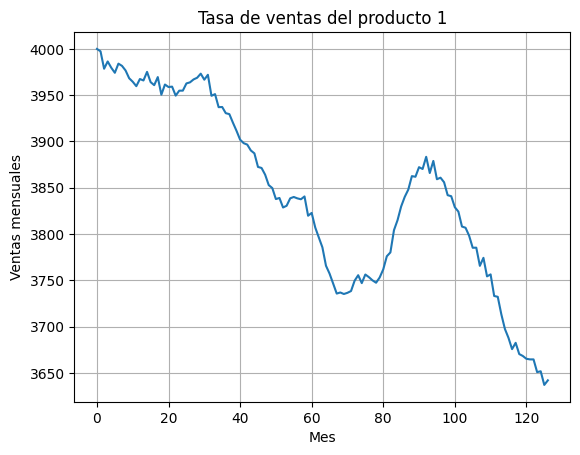

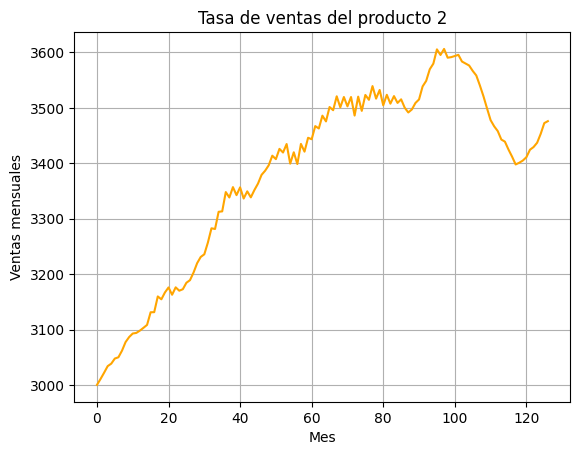

In [8]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos de producto1 y produto2
plt.title("Tasa de ventas del producto 1")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto1"]])
plt.grid()
plt.show()

plt.title("Tasa de ventas del producto 2")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto2"]], color='orange')
plt.grid()
plt.show()

## **3. EDA**

### 3.1 Procedemos a hacer un análisis corto de EDA para verificar tamaño del conjunto de datos para cada serie de tiempo, nulos (si hay) y algunas cuantificaciones estadísticas

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  127 non-null    int64  
 1   producto1   127 non-null    float64
 2   producto2   127 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.1 KB


In [10]:
#Determinamos si existen nulos en las series de tiempo
data.isnull().sum()

Unnamed: 0    0
producto1     0
producto2     0
dtype: int64

In [13]:
# Estadsiticas del conjunto de datos de tendencia central
data.describe()

,Unnamed: 0,producto1,producto2
count,127.000000,127.000000,127.000000
mean,64.000000,3843.571660,3381.037664
std,36.805797,100.234821,167.504363
min,1.000000,3637.047639,3000.000000
25%,32.500000,3756.853812,3269.194001
50%,64.000000,3840.644019,3426.048401
75%,95.500000,3950.071775,3508.941718
max,127.000000,4000.000000,3606.440615


### 3.2 Ahora debemos convertir en índice la variable sin nombre: 'Unnamed: 0'  que representa los meses desde enero del 2008 como lo indica el enunciado del problema y expresarla en forma de fecha para mejorar el entendimiento y procesamiento

In [16]:
# Renombrar la columna 'Unnamed: 0' a 'Mes'
data.rename(columns={'Unnamed: 0': 'Mes'}, inplace=True)

# Función para convertir un número de mes a la última fecha de cada mes
def convertir_mes_a_fecha_final(mes, start_date):
    year = start_date.year + (mes - 1) // 12
    month = (start_date.month + (mes - 1) % 12 - 1) % 12 + 1
    #Obtener el último día del mes
    last_day = monthrange(year, month)[1]
    return datetime(year, month, last_day)

# Fecha de inicio (enero de 2008)
start_date = datetime(2008, 1, 1)

# Aplicar la función a la columna 'Mes'
data['Mes'] = data['Mes'].apply(lambda x: convertir_mes_a_fecha_final(x, start_date))

print(data)


           Mes    producto1    producto2
0   2008-01-31  4000.000000  3000.000000
1   2008-02-29  3997.400893  3010.686220
2   2008-03-31  3978.605317  3022.018584
3   2008-04-30  3986.454125  3033.920990
4   2008-05-31  3979.695678  3038.402098
..         ...          ...          ...
122 2018-03-31  3664.610771  3429.293034
123 2018-04-30  3650.881839  3437.099467
124 2018-05-31  3651.788470  3453.155282
125 2018-06-30  3637.047639  3472.528345
126 2018-07-31  3641.990873  3476.058092

[127 rows x 3 columns]


In [17]:
# Establecer la columna 'Mes' como índice
data.set_index('Mes', inplace=True)

print(data)

              producto1    producto2
Mes                                 
2008-01-31  4000.000000  3000.000000
2008-02-29  3997.400893  3010.686220
2008-03-31  3978.605317  3022.018584
2008-04-30  3986.454125  3033.920990
2008-05-31  3979.695678  3038.402098
...                 ...          ...
2018-03-31  3664.610771  3429.293034
2018-04-30  3650.881839  3437.099467
2018-05-31  3651.788470  3453.155282
2018-06-30  3637.047639  3472.528345
2018-07-31  3641.990873  3476.058092

[127 rows x 2 columns]


In [18]:
#miramos nuevamente como queda el dataframe con estas transformaciones
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2008-01-31 to 2018-07-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   producto1  127 non-null    float64
 1   producto2  127 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


In [19]:
data.shape

(127, 2)

In [20]:
#Determinamos si existen nulos en las series de tiempo
data.isnull().sum()

producto1    0
producto2    0
dtype: int64

In [21]:
# Estadsiticas del conjunto de datos de tendencia central
data.describe()

,producto1,producto2
count,127.000000,127.000000
mean,3843.571660,3381.037664
std,100.234821,167.504363
min,3637.047639,3000.000000
25%,3756.853812,3269.194001
50%,3840.644019,3426.048401
75%,3950.071775,3508.941718
max,4000.000000,3606.440615


### 3.3 Ya con esta pequeñas transformaciones tenemos nuestro conjunto de datos listo para trabajarlo y proceder a hacer todo lo necesario para llevar a cabo los pronósticos de cada serie de tiempo de los dos prodcutos estrellas de la empresa

(127, 2)


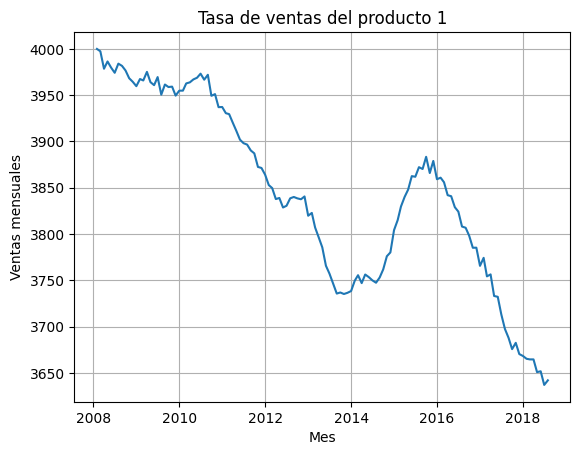

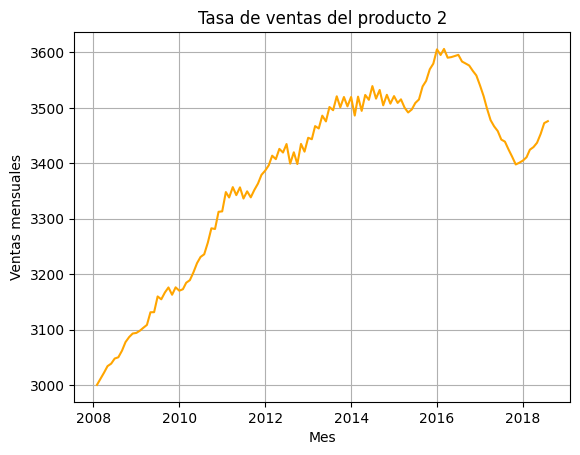

In [23]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos de producto1 y produto2
plt.title("Tasa de ventas del producto 1")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto1"]])
plt.grid()
plt.show()

plt.title("Tasa de ventas del producto 2")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto2"]], color='orange')
plt.grid()
plt.show()

### 3.4 Encontrando los componentes de las series de tiempo para los productos 1 y 2

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose.

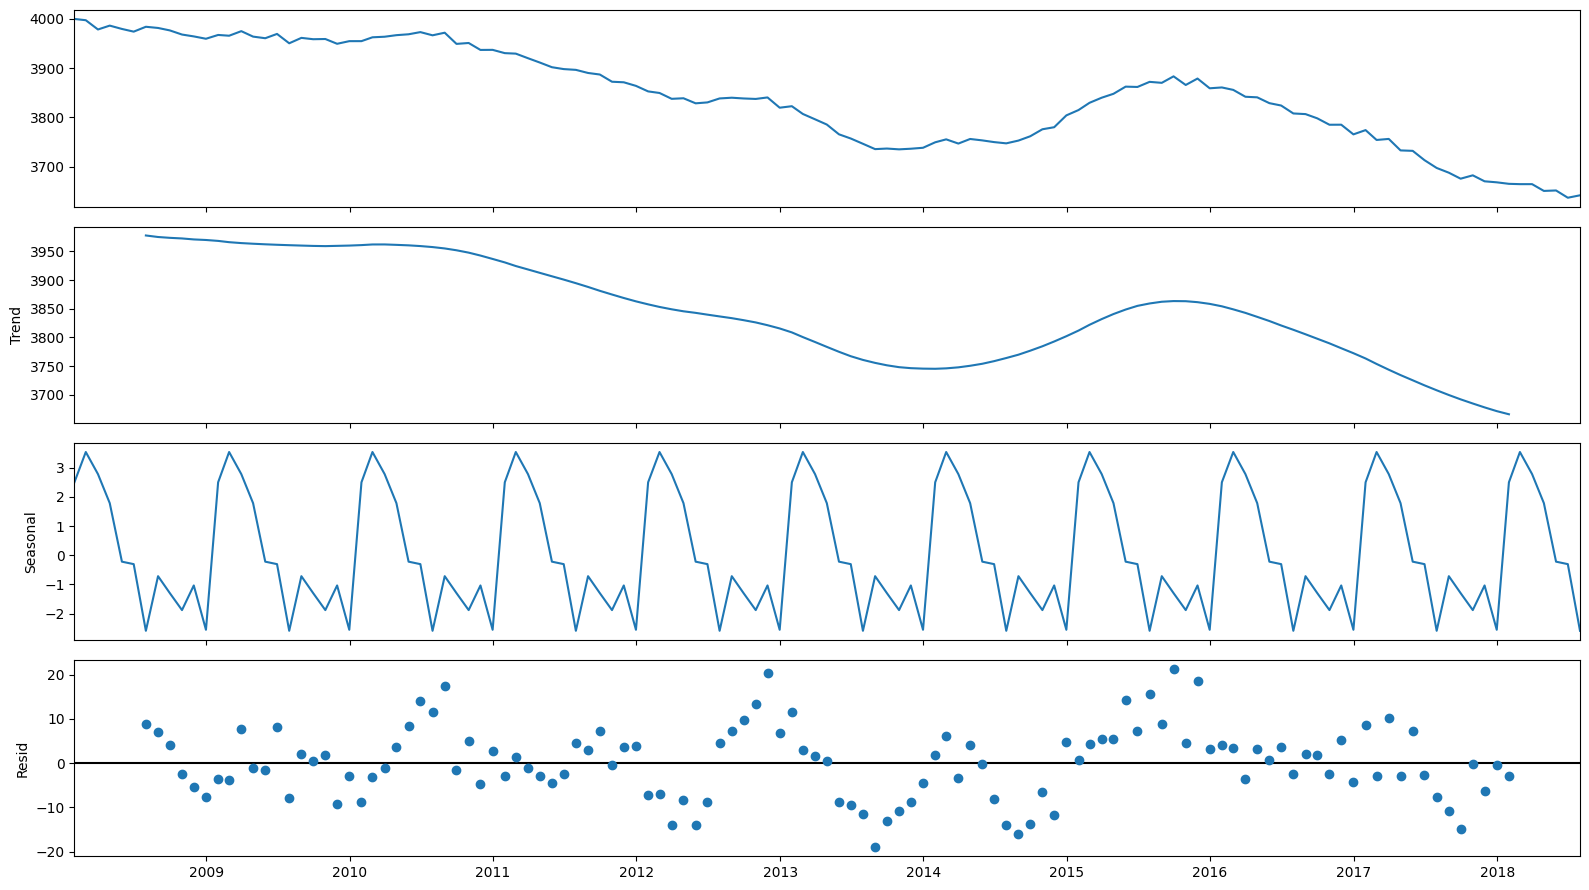

In [24]:
#Componentes serie de tiempo prodcuto1
td_componentes_producto1 = seasonal_decompose(data[["producto1"]],model="additive")
fig = td_componentes_producto1.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

**Podemos observar el componente estacional marcado en la serie de producto1, una tendencia no lineal de los datos y la parte aleatoria.**

Observamos cada componente de la serie de tiempo del producto1

In [25]:
td_componentes_producto1.seasonal

Mes
2008-01-31    2.495315
2008-02-29    3.531537
2008-03-31    2.775396
2008-04-30    1.781834
2008-05-31   -0.220084
                ...   
2018-03-31    2.775396
2018-04-30    1.781834
2018-05-31   -0.220084
2018-06-30   -0.304548
2018-07-31   -2.585303
Name: seasonal, Length: 127, dtype: float64

In [26]:
td_componentes_producto1.trend

Mes
2008-01-31   NaN
2008-02-29   NaN
2008-03-31   NaN
2008-04-30   NaN
2008-05-31   NaN
              ..
2018-03-31   NaN
2018-04-30   NaN
2018-05-31   NaN
2018-06-30   NaN
2018-07-31   NaN
Name: trend, Length: 127, dtype: float64

In [27]:
td_componentes_producto1.resid

Mes
2008-01-31   NaN
2008-02-29   NaN
2008-03-31   NaN
2008-04-30   NaN
2008-05-31   NaN
              ..
2018-03-31   NaN
2018-04-30   NaN
2018-05-31   NaN
2018-06-30   NaN
2018-07-31   NaN
Name: resid, Length: 127, dtype: float64

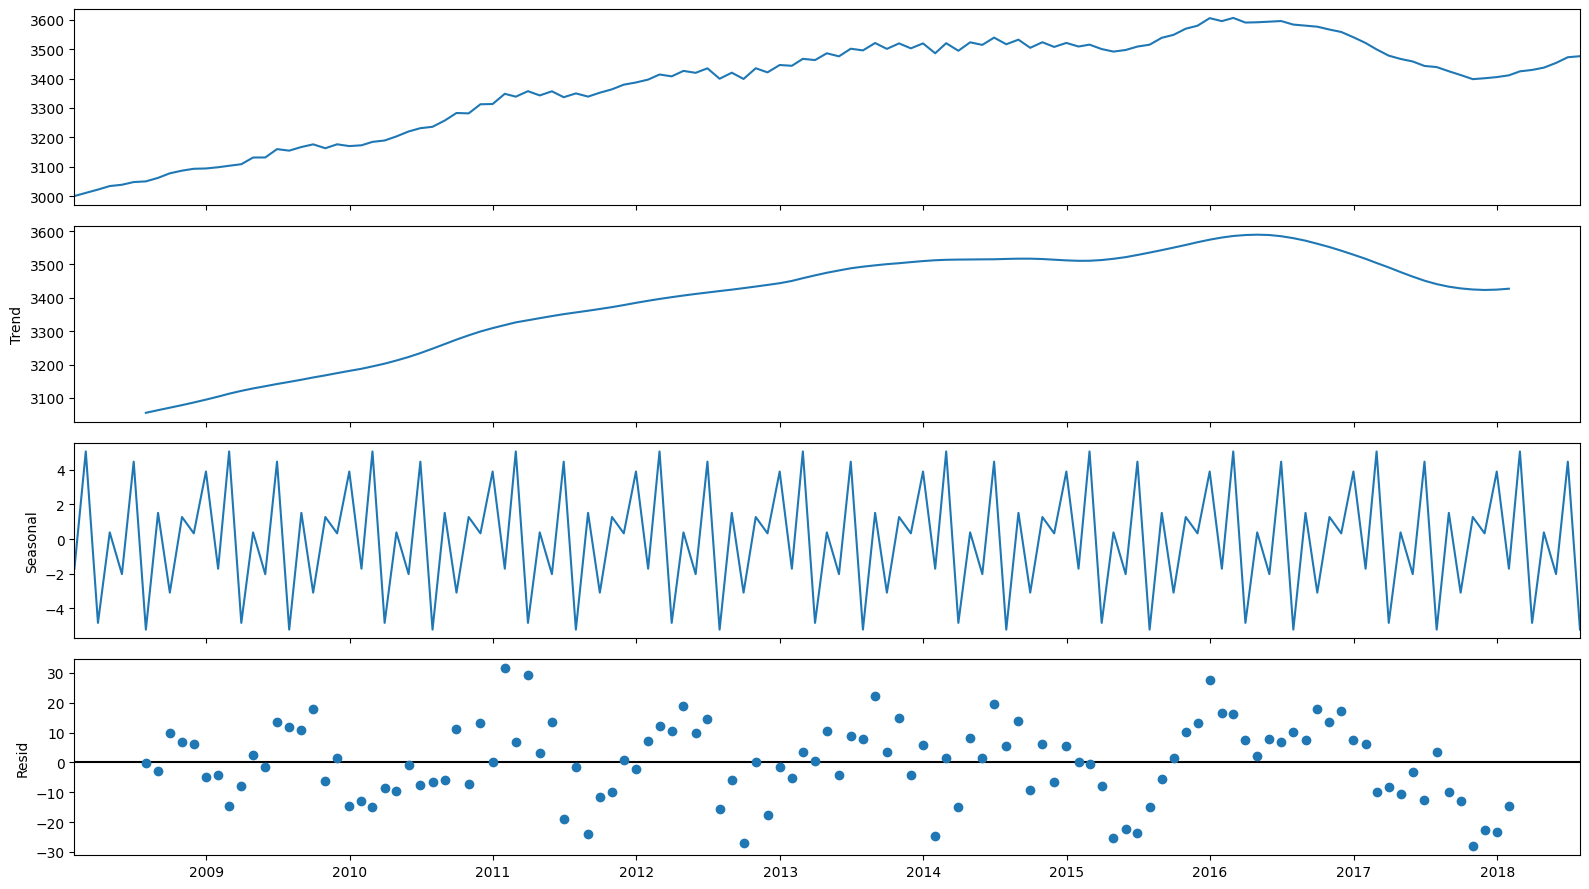

In [28]:
#Componentes serie de tiempo prodcuto2
td_componentes_producto2 = seasonal_decompose(data[["producto2"]],model="additive")
fig = td_componentes_producto2.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

**Podemos observar el componente estacional marcado en la serie producto2, una tendencia no lineal de los datos y la parte aleatoria.**

Observamos cada componente de la serie de tiempo del producto2

In [29]:
td_componentes_producto2.seasonal

Mes
2008-01-31   -1.709341
2008-02-29    5.041275
2008-03-31   -4.827994
2008-04-30    0.382215
2008-05-31   -2.021890
                ...   
2018-03-31   -4.827994
2018-04-30    0.382215
2018-05-31   -2.021890
2018-06-30    4.453935
2018-07-31   -5.214986
Name: seasonal, Length: 127, dtype: float64

In [30]:
td_componentes_producto2.trend

Mes
2008-01-31   NaN
2008-02-29   NaN
2008-03-31   NaN
2008-04-30   NaN
2008-05-31   NaN
              ..
2018-03-31   NaN
2018-04-30   NaN
2018-05-31   NaN
2018-06-30   NaN
2018-07-31   NaN
Name: trend, Length: 127, dtype: float64

In [31]:
td_componentes_producto2.resid

Mes
2008-01-31   NaN
2008-02-29   NaN
2008-03-31   NaN
2008-04-30   NaN
2008-05-31   NaN
              ..
2018-03-31   NaN
2018-04-30   NaN
2018-05-31   NaN
2018-06-30   NaN
2018-07-31   NaN
Name: resid, Length: 127, dtype: float64

Procedemos a realizar una gráfica para comparar ambas series donde vemos el comportamiento de cada producto respecto al otro

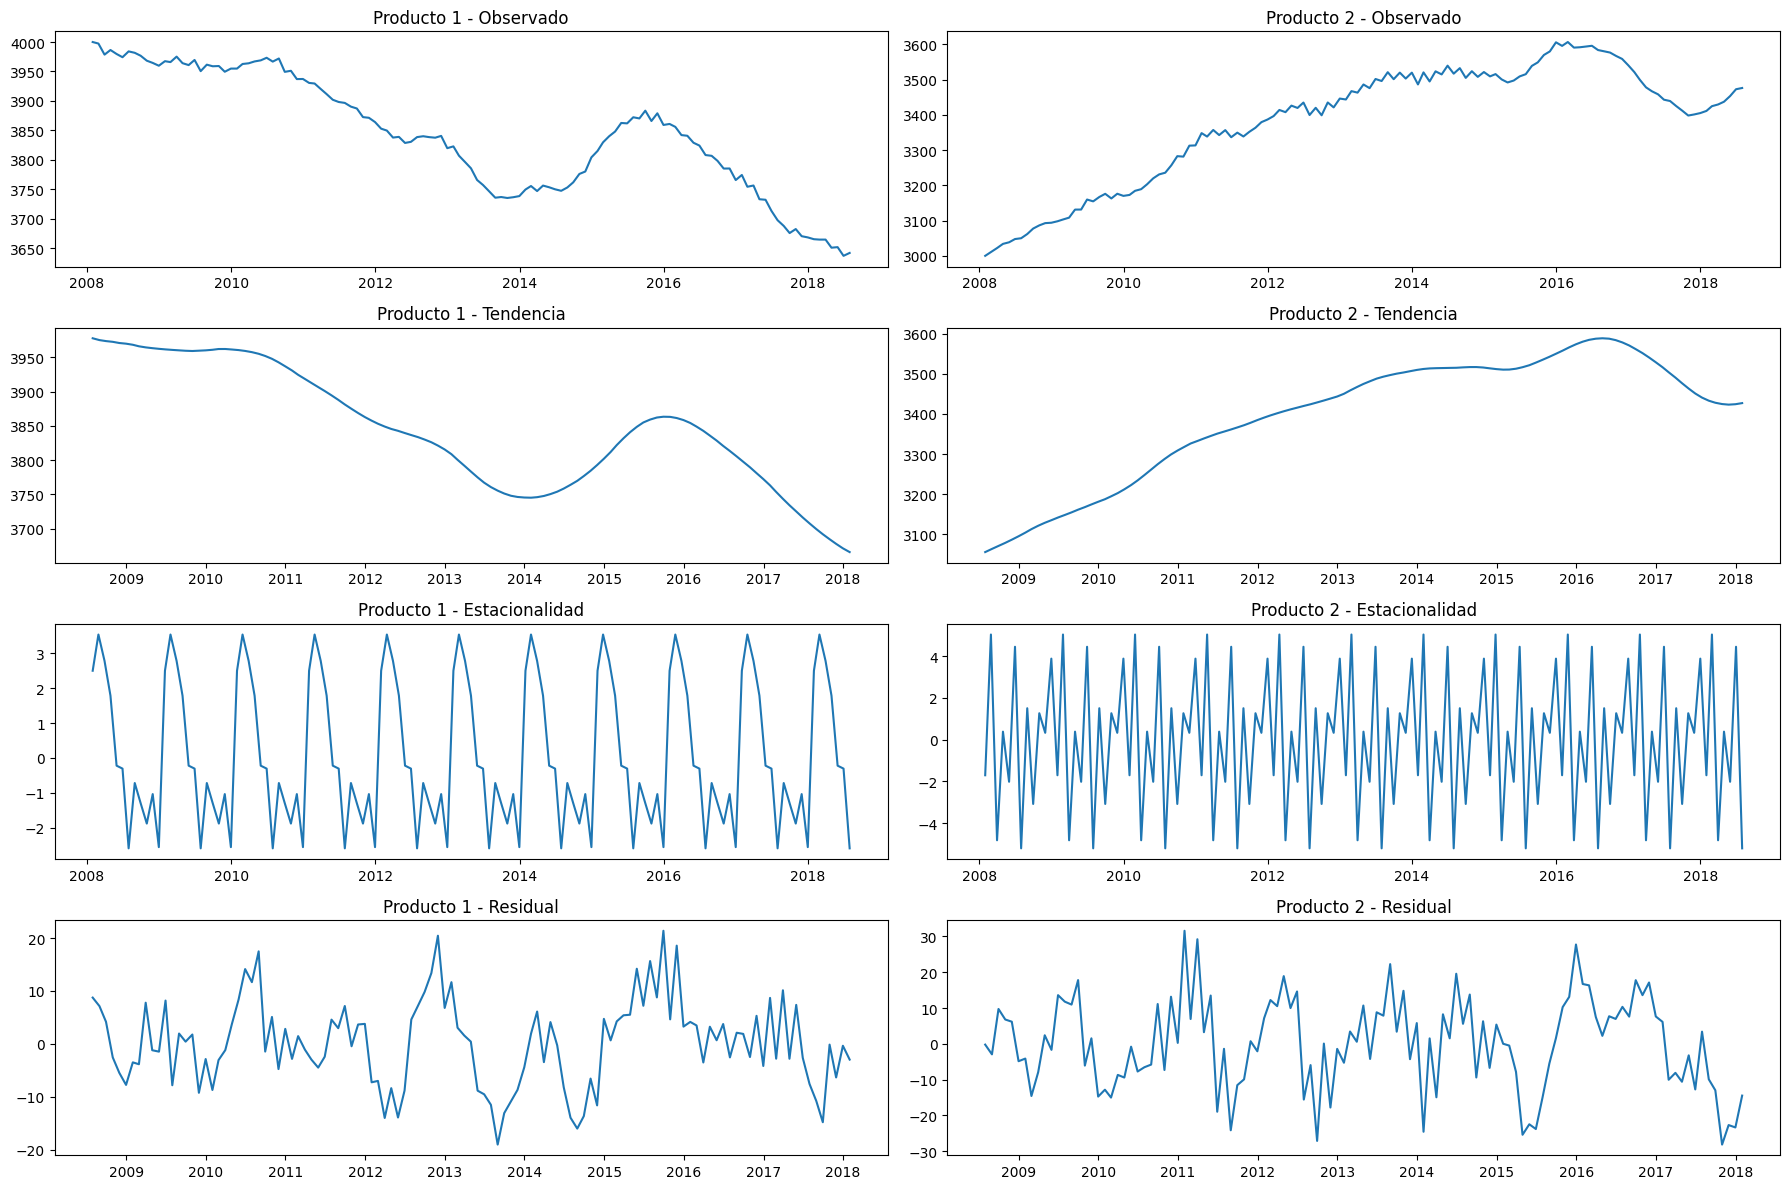

In [32]:
# Crear subplots
fig, axes = plt.subplots(4, 2, figsize=(18, 12))

# Graficar los componentes de producto1
axes[0, 0].plot(td_componentes_producto1.observed)
axes[0, 0].set_title('Producto 1 - Observado')
axes[1, 0].plot(td_componentes_producto1.trend)
axes[1, 0].set_title('Producto 1 - Tendencia')
axes[2, 0].plot(td_componentes_producto1.seasonal)
axes[2, 0].set_title('Producto 1 - Estacionalidad')
axes[3, 0].plot(td_componentes_producto1.resid)
axes[3, 0].set_title('Producto 1 - Residual')

# Graficar los componentes de producto2
axes[0, 1].plot(td_componentes_producto2.observed)
axes[0, 1].set_title('Producto 2 - Observado')
axes[1, 1].plot(td_componentes_producto2.trend)
axes[1, 1].set_title('Producto 2 - Tendencia')
axes[2, 1].plot(td_componentes_producto2.seasonal)
axes[2, 1].set_title('Producto 2 - Estacionalidad')
axes[3, 1].plot(td_componentes_producto2.resid)
axes[3, 1].set_title('Producto 2 - Residual')

# Ajustar el layout
plt.tight_layout()
plt.show()

Aquí notamos que la tendencia de cada producto ha sido inversa es decir: el producto1 tiene una tendencia hacia la baja y el producto2 una tendencia a la alza; pero debemos observar que también a pesar de esto al final ambos prodcutos se encuentran en una ventas similares en cantidad aunque aún vende más el producto1. 

Como observamos una estacionalidad fuerte en ambas, haremos un experimento creando sus 2 versiones sin estacionalidad... para así aplicar los modelos y protocolos de evaluación y comprar cual sería mejor.

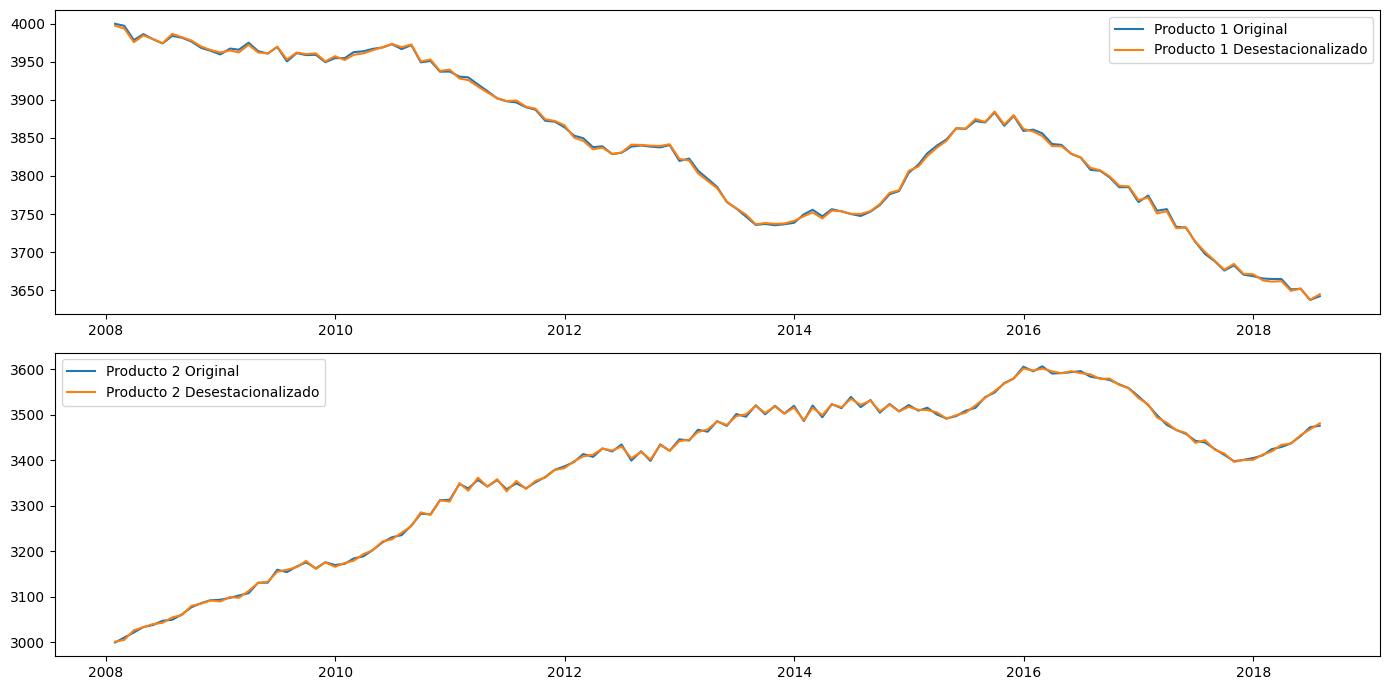

,producto1,producto2,producto1_desestacionalizado,producto2_desestacionalizado
Mes,,,,
2008-01-31,4000.000000,3000.000000,3997.504685,3001.709341
2008-02-29,3997.400893,3010.686220,3993.869356,3005.644945
2008-03-31,3978.605317,3022.018584,3975.829921,3026.846578
2008-04-30,3986.454125,3033.920990,3984.672292,3033.538775
2008-05-31,3979.695678,3038.402098,3979.915762,3040.423988


In [41]:
# Guardar la serie desestacionalizada para producto1
data['producto1_desestacionalizado'] = data['producto1'] - td_componentes_producto1.seasonal

# Guardar la serie desestacionalizada para producto2
data['producto2_desestacionalizado'] = data['producto2'] - td_componentes_producto2.seasonal

# Graficar para ver las series originales y desestacionalizadas
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(data.index, data['producto1'], label='Producto 1 Original')
plt.plot(data.index, data['producto1_desestacionalizado'], label='Producto 1 Desestacionalizado')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data.index, data['producto2'], label='Producto 2 Original')
plt.plot(data.index, data['producto2_desestacionalizado'], label='Producto 2 Desestacionalizado')
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar las primeras filas del DataFrame para verificar
data.head()


## **4. PROTOCOLOS DE EVALUACION**

Al inicio había hecho un train y test donde el test tenía solo el ultimo dato, pensando en los ejercicios anteriores.. NOta! 

### **4.1 Ventana Recursiva**

En un enfoque de ventana recursiva, entrenas el modelo con un conjunto de datos y luego lo usas para predecir un punto en el futuro. Después de obtener la predicción, amplías la ventana para incluir este nuevo punto y repites el proceso.

![alt text](recursive-window.png)

### **4.2 Rolling window**

En una rolling window, mueves la ventana a lo largo del tiempo para generar predicciones, entrenando el modelo solo en los datos más recientes.

![image.png](rolling-window.png)

Dependiendo del modelo a usar se deben hacer algunos ajustes a las funciones para el correcto funcionamiento del protocolo de evaluación

Se implementan las funciones para evaluar los modelos utilizando ambos protocolos y otra para el cálculo del RMSE.

In [46]:
def evaluacion_ventana_recursiva_un_paso(series, model_func, params, initial_train_size=12):
    predictions = []
    train = series[:initial_train_size].copy()  # Conjunto inicial de entrenamiento
    
    for i in range(initial_train_size, len(series)):
        # Ajustar el modelo con los datos de entrenamiento
        prediction = model_func(train, **params)
        predictions.append(prediction)  # Guardar la predicción
        
        # Expandir la ventana de entrenamiento con el valor real
        train = pd.concat([train, series[i:i+1]])
    
    return predictions


"""
# Evaluación con Ventana Recursiva
def evaluacion_ventana_recursiva_un_paso(series, model_func, params, initial_train_size=12):
    predictions = []
    train = series[:initial_train_size].copy()  # Conjunto inicial de entrenamiento
    
    for i in range(initial_train_size, len(series)):
        # Ajustar el modelo con los datos de entrenamiento
        model = model_func(train, **params)
        
        # Hacer la predicción de un paso adelante (un mes)
        forecast = model.forecast(steps=1)
        predictions.append(forecast[0])  # Guardar la predicción
        
        # Expandir la ventana de entrenamiento con el valor real
        train = pd.concat([train, series[i:i+1]])
    
    return predictions
"""

'\n# Evaluación con Ventana Recursiva\ndef evaluacion_ventana_recursiva_un_paso(series, model_func, params, initial_train_size=12):\n    predictions = []\n    train = series[:initial_train_size].copy()  # Conjunto inicial de entrenamiento\n    \n    for i in range(initial_train_size, len(series)):\n        # Ajustar el modelo con los datos de entrenamiento\n        model = model_func(train, **params)\n        \n        # Hacer la predicción de un paso adelante (un mes)\n        forecast = model.forecast(steps=1)\n        predictions.append(forecast[0])  # Guardar la predicción\n        \n        # Expandir la ventana de entrenamiento con el valor real\n        train = pd.concat([train, series[i:i+1]])\n    \n    return predictions\n'

In [47]:
def evaluacion_rolling_window_un_paso(series, model_func, params, window_size=12):
    predictions = []
    for i in range(window_size, len(series)):
        # Definir la ventana de entrenamiento
        train = series[i-window_size:i]
        
        # Ajustar el modelo en la ventana de entrenamiento y predecir el siguiente valor
        prediction = model_func(train, **params)
        predictions.append(prediction)
    
    return predictions


"""
# Evaluación con Rolling Window
def evaluacion_rolling_window_un_paso(series, model_func, params, window_size=12):
    predictions = []
    
    for i in range(window_size, len(series)):
        # Definir la ventana de entrenamiento de tamaño fijo
        train = series[i-window_size:i]
        
        # Ajustar el modelo en la ventana de entrenamiento
        model = model_func(train, **params)
        
        # Hacer la predicción de un paso adelante (un mes)
        forecast = model.forecast(steps=1)
        predictions.append(forecast[0])  # Guardar la predicción
    
    return predictions
"""

'\n# Evaluación con Rolling Window\ndef evaluacion_rolling_window_un_paso(series, model_func, params, window_size=12):\n    predictions = []\n    \n    for i in range(window_size, len(series)):\n        # Definir la ventana de entrenamiento de tamaño fijo\n        train = series[i-window_size:i]\n        \n        # Ajustar el modelo en la ventana de entrenamiento\n        model = model_func(train, **params)\n        \n        # Hacer la predicción de un paso adelante (un mes)\n        forecast = model.forecast(steps=1)\n        predictions.append(forecast[0])  # Guardar la predicción\n    \n    return predictions\n'

In [50]:
# Cálculo del RMSE que será nuestra medida para seleccionar el mejor modelo
def calculate_rmse(true_values, predictions):
    # Si el tamaño de las predicciones es menor, ajustamos los valores reales para coincidir
    if len(predictions) < len(true_values):
        true_values = true_values[-len(predictions):]
    elif len(predictions) > len(true_values):
        raise ValueError("El número de predicciones no puede ser mayor que el número de valores reales.")
    
    return np.sqrt(mean_squared_error(true_values, predictions))


También definimos una función para ir almacenando los resultados

In [56]:
# Función para agregar los resultados al DataFrame usando pd.concat
def agregar_resultados_al_dataframe(modelo, resultados_rolling, resultados_recursivos, hiperparametros=None):
    global resultados_df  # Usamos el DataFrame global
    
    for serie_nombre in resultados_rolling.keys():
        # Agregar resultados de Rolling Window
        for window, rmse in resultados_rolling[serie_nombre].items():
            # Crear un DataFrame temporal con la nueva fila
            nuevo_df = pd.DataFrame({
                'Modelo': [modelo],
                'Serie': [serie_nombre],
                'Protocolo': ['Rolling Window'],
                'Ventana': [window],
                'RMSE': [rmse],
                'Hiperparametros': [hiperparametros if hiperparametros else {}]
            })
            # Usar pd.concat para agregar la nueva fila
            resultados_df = pd.concat([resultados_df, nuevo_df], ignore_index=True)
        
        # Agregar resultados de Ventana Recursiva
        for window, rmse in resultados_recursivos[serie_nombre].items():
            # Crear un DataFrame temporal con la nueva fila
            nuevo_df = pd.DataFrame({
                'Modelo': [modelo],
                'Serie': [serie_nombre],
                'Protocolo': ['Ventana Recursiva'],
                'Ventana': [window],
                'RMSE': [rmse],
                'Hiperparametros': [hiperparametros if hiperparametros else {}]
            })
            # Usar pd.concat para agregar la nueva fila
            resultados_df = pd.concat([resultados_df, nuevo_df], ignore_index=True)

También diseñamos una función para graficar los resultados

In [78]:
# Función para graficar RMSE para modelos con y sin ventana
def graficar_separado_por_protocolo_y_serie(resultados_df):
    # Iterar sobre cada serie para crear gráficos separados
    for serie in resultados_df['Serie'].unique():
        # Filtrar los datos por serie
        df_serie = resultados_df[resultados_df['Serie'] == serie]
        
        # Crear la figura con dos subgráficos, uno para cada protocolo
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 fila, 2 columnas
        
        # --- Gráfico de Ventana Recursiva ---
        df_ventana_recursiva = df_serie[df_serie['Protocolo'] == 'Ventana Recursiva']
        
        if 'Ventana' in df_ventana_recursiva.columns:
            sns.lineplot(
                data=df_ventana_recursiva, 
                x='Ventana', 
                y='RMSE', 
                hue='Modelo', 
                markers=True, 
                dashes=False, 
                ax=axes[0]
            )
        else:
            sns.lineplot(
                data=df_ventana_recursiva, 
                x='Hiperparametros',  # Suponiendo que otros modelos tienen una columna de hiperparámetros
                y='RMSE', 
                hue='Modelo', 
                markers=True, 
                dashes=False, 
                ax=axes[0]
            )
        axes[0].set_title(f'Ventana Recursiva - {serie}', fontsize=14)
        axes[0].set_xlabel('Tamaño de Ventana' if 'Ventana' in df_ventana_recursiva.columns else 'Hiperparámetros', fontsize=12)
        axes[0].set_ylabel('RMSE', fontsize=12)
        axes[0].grid(True)

        # Mostrar los valores de RMSE en cada punto
        for i in range(df_ventana_recursiva.shape[0]):
            axes[0].text(
                df_ventana_recursiva['Ventana'].values[i] if 'Ventana' in df_ventana_recursiva.columns else df_ventana_recursiva['Hiperparametros'].values[i], 
                df_ventana_recursiva['RMSE'].values[i], 
                f"{df_ventana_recursiva['RMSE'].values[i]:.2f}", 
                ha="center", va="bottom"
            )

        # --- Gráfico de Rolling Window ---
        df_rolling_window = df_serie[df_serie['Protocolo'] == 'Rolling Window']
        
        if 'Ventana' in df_rolling_window.columns:
            sns.lineplot(
                data=df_rolling_window, 
                x='Ventana', 
                y='RMSE', 
                hue='Modelo', 
                markers=True, 
                dashes=False, 
                ax=axes[1]
            )
        else:
            sns.lineplot(
                data=df_rolling_window, 
                x='Hiperparametros', 
                y='RMSE', 
                hue='Modelo', 
                markers=True, 
                dashes=False, 
                ax=axes[1]
            )
        axes[1].set_title(f'Rolling Window - {serie}', fontsize=14)
        axes[1].set_xlabel('Tamaño de Ventana' if 'Ventana' in df_rolling_window.columns else 'Hiperparámetros', fontsize=12)
        axes[1].set_ylabel('RMSE', fontsize=12)
        axes[1].grid(True)

        # Mostrar los valores de RMSE en cada punto
        for i in range(df_rolling_window.shape[0]):
            axes[1].text(
                df_rolling_window['Ventana'].values[i] if 'Ventana' in df_rolling_window.columns else df_rolling_window['Hiperparametros'].values[i], 
                df_rolling_window['RMSE'].values[i], 
                f"{df_rolling_window['RMSE'].values[i]:.2f}", 
                ha="center", va="bottom"
            )
        
        # Ajustar la leyenda y el espaciado
        plt.tight_layout()
        plt.show()


Y una función para graficar los mejores modelos

In [98]:
# Función para graficar los mejores modelos, mostrando RMSE, ventana y/o hiperparámetros
def graficar_mejores_modelos_con_parametros(mejores_modelos):
    plt.figure(figsize=(10, 6))

    # Crear un gráfico de barras para visualizar el RMSE de los mejores modelos
    sns.barplot(
        data=mejores_modelos, 
        x='Serie', 
        y='RMSE', 
        hue='Mejor Modelo'
    )
    
    # Añadir los valores de RMSE, ventana e hiperparámetros en cada barra
    for i in range(mejores_modelos.shape[0]):
        ventana = mejores_modelos['Ventana'].values[i]
        hiperparametros = mejores_modelos['Hiperparámetros'].values[i]
        rmse = mejores_modelos['RMSE'].values[i]
        
        # Preparar el texto para mostrar ventana y/o hiperparámetros
        extra_info = f"RMSE: {rmse:.2f}"
        if ventana:
            extra_info += f", Ventana: {ventana}"
        if hiperparametros:
            extra_info += f", Hiperparámetros: {hiperparametros}"

        # Colocar el texto encima de la barra
        plt.text(
            i, 
            rmse + 0.1,  # Ajustar el texto justo por encima de la barra
            extra_info, 
            ha='center', 
            va='bottom', 
            fontsize=9
        )
    
    # Ajustar el título y etiquetas
    plt.title('Mejores Modelos por Serie con RMSE, Ventana y Hiperparámetros', fontsize=16)
    plt.xlabel('Serie', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    
    # Mostrar la leyenda
    plt.legend(title='Mejor Modelo')
    
    # Mostrar el gráfico
    plt.show()

Diseñamos una función de la métrica RMSE, el modelo con el menor valor de RMSE será considerado el mejor para cada serie de tiempo

In [97]:
# Función general para seleccionar el mejor modelo, independientemente del tipo de modelo o hiperparámetro
def seleccionar_mejor_modelo_con_hiperparametros(resultados_df):
    # Crear un DataFrame vacío para almacenar los mejores modelos
    mejores_modelos = pd.DataFrame(columns=['Serie', 'Mejor Modelo', 'Protocolo', 'Ventana', 'Hiperparámetros', 'RMSE'])

    # Iterar sobre cada serie para encontrar el mejor modelo
    for serie in resultados_df['Serie'].unique():
        # Filtrar los resultados para la serie específica
        df_serie = resultados_df[resultados_df['Serie'] == serie]

        # Encontrar la fila con el RMSE más bajo
        mejor_fila = df_serie.loc[df_serie['RMSE'].idxmin()]

        # Capturar la ventana si existe
        ventana = mejor_fila['Ventana'] if 'Ventana' in mejor_fila else None
        
        # Capturar los hiperparámetros si existen
        hiperparametros = mejor_fila['Hiperparámetros'] if 'Hiperparámetros' in mejor_fila else None

        # Incluir cualquier otro tipo de hiperparámetro relevante
        if mejor_fila['Modelo'] == 'Regresión Polinómica':
            hiperparametros = f"Grado: {mejor_fila['Grado']}"  # Para regresión polinómica

        # Crear un DataFrame temporal con la fila seleccionada
        nuevo_df = pd.DataFrame({
            'Serie': [serie],
            'Mejor Modelo': [mejor_fila['Modelo']],
            'Protocolo': [mejor_fila['Protocolo']],
            'Ventana': [ventana],
            'Hiperparámetros': [hiperparametros],
            'RMSE': [mejor_fila['RMSE']]
        })

        # Usar pd.concat para agregar la nueva fila al DataFrame de mejores modelos
        mejores_modelos = pd.concat([mejores_modelos, nuevo_df], ignore_index=True)
    
    return mejores_modelos

## **5. MODELOS**

Implementaremos funciones para:

- Promedio Móvil.

- Suavización Exponencial (Simple, Holt, Holt-Winters).

- Regresion (Polinomios + Estacionalidad)

- ARIMA.

### **5.1 PROMEDIO MOVIL**

Primero desarrollamos el modelo sólo al final le adaptaremos una optimización bayesiana

In [52]:
# Definir el modelo de Promedio Móvil
def modelo_promedio_movil(train, window):
    # Calcular el promedio móvil de los últimos 'window' períodos
    rolling_mean = train.rolling(window=window).mean()
    # Retornar el último valor del promedio móvil (la predicción)
    return rolling_mean.iloc[-1] if not rolling_mean.isna().all() else train.iloc[-1]

# Evaluar Promedio Móvil con el RMSE ajustado
def evaluar_promedio_movil_para_ventanas(series, window_sizes, eval_func, **eval_params):
    resultados = {}
    for window in window_sizes:
        # Definir los parámetros del modelo
        params = {'window': window}
        # Evaluar la serie para la ventana actual usando el protocolo de evaluación
        predicciones = eval_func(series, model_func=modelo_promedio_movil, params=params, **eval_params)
        
        # Calcular el RMSE para la ventana actual con el nuevo enfoque
        rmse = calculate_rmse(series[len(series) - len(predicciones):], predicciones)
        resultados[window] = rmse
    
    return resultados

# Definir las series que vamos a evaluar
series_a_evaluar = {
    'producto1': data['producto1'],
    'producto1_desestacionalizado': data['producto1_desestacionalizado'],
    'producto2': data['producto2'],
    'producto2_desestacionalizado': data['producto2_desestacionalizado']
}

# Definir las ventanas para el Promedio Móvil
window_sizes = list(range(2, 11))  # Ventanas de 2 a 10

# Resultados para cada serie y protocolo de evaluación
resultados_rolling = {}
resultados_recursivos = {}

# Evaluar Promedio Móvil para las 4 series con ambos protocolos
for serie_nombre, serie in series_a_evaluar.items():
    print(f"Evaluando {serie_nombre}...")
    
    # Evaluación con Rolling Window
    resultados_rolling[serie_nombre] = evaluar_promedio_movil_para_ventanas(
        serie, 
        window_sizes, 
        eval_func=evaluacion_rolling_window_un_paso, 
        window_size=12
    )
    
    # Evaluación con Ventana Recursiva
    resultados_recursivos[serie_nombre] = evaluar_promedio_movil_para_ventanas(
        serie, 
        window_sizes, 
        eval_func=evaluacion_ventana_recursiva_un_paso, 
        initial_train_size=12
    )


Evaluando producto1...
Evaluando producto1_desestacionalizado...
Evaluando producto2...
Evaluando producto2_desestacionalizado...


Observamos los resultados obtenidos y los guardamos en un dataframe

In [58]:
# Agregar resultados del modelo Promedio Móvil con las ventanas de 2 a 10
modelo = "Promedio Móvil"
agregar_resultados_al_dataframe(modelo, resultados_rolling, resultados_recursivos)

# Mostrar el DataFrame
resultados_df


,Modelo,Serie,Protocolo,Ventana,RMSE,Hiperparametros
0,Promedio Móvil,producto1,Rolling Window,2,11.491006,{}
1,Promedio Móvil,producto1,Rolling Window,3,14.553967,{}
2,Promedio Móvil,producto1,Rolling Window,4,17.513618,{}
3,Promedio Móvil,producto1,Rolling Window,5,20.464860,{}
4,Promedio Móvil,producto1,Rolling Window,6,23.365749,{}
...,...,...,...,...,...,...
139,Promedio Móvil,producto2_desestacionalizado,Ventana Recursiva,6,30.814001,{}
140,Promedio Móvil,producto2_desestacionalizado,Ventana Recursiva,7,34.308375,{}
141,Promedio Móvil,producto2_desestacionalizado,Ventana Recursiva,8,37.496790,{}
142,Promedio Móvil,producto2_desestacionalizado,Ventana Recursiva,9,40.678300,{}


Ahora graficamos estos resultados para verlos graficamente de una mejor manera

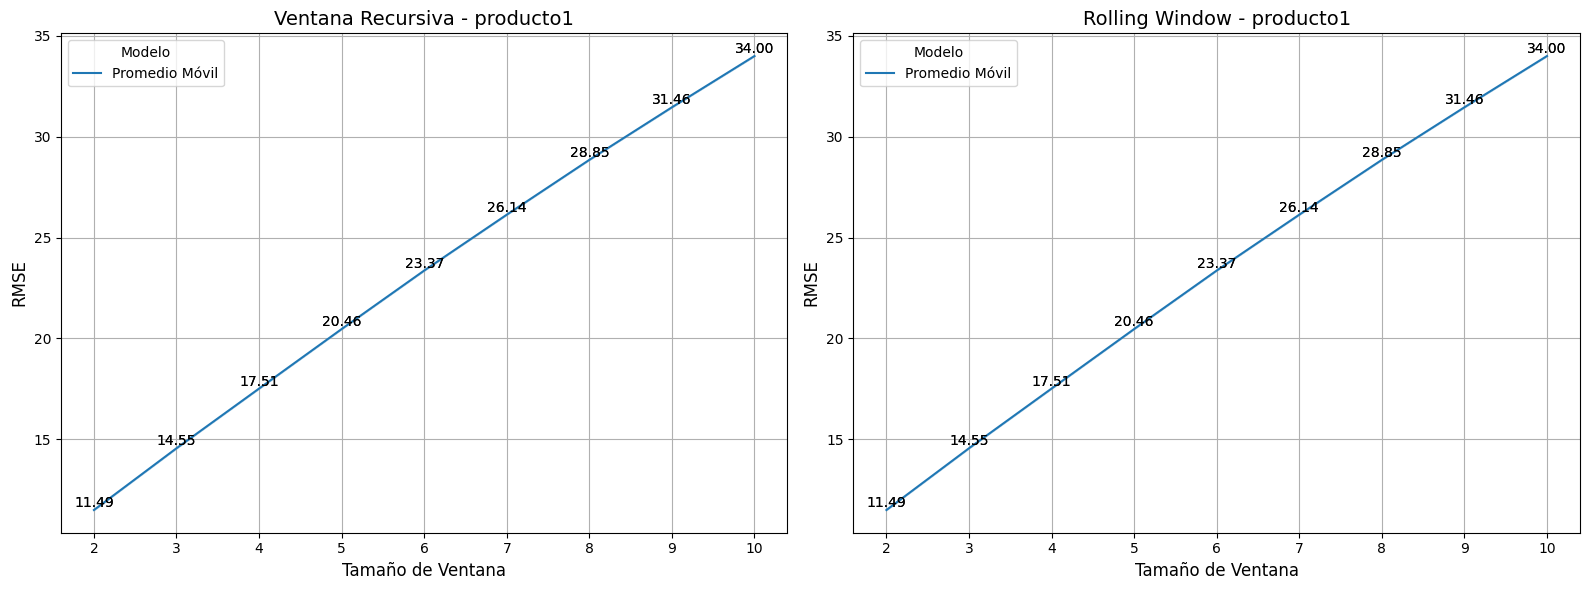

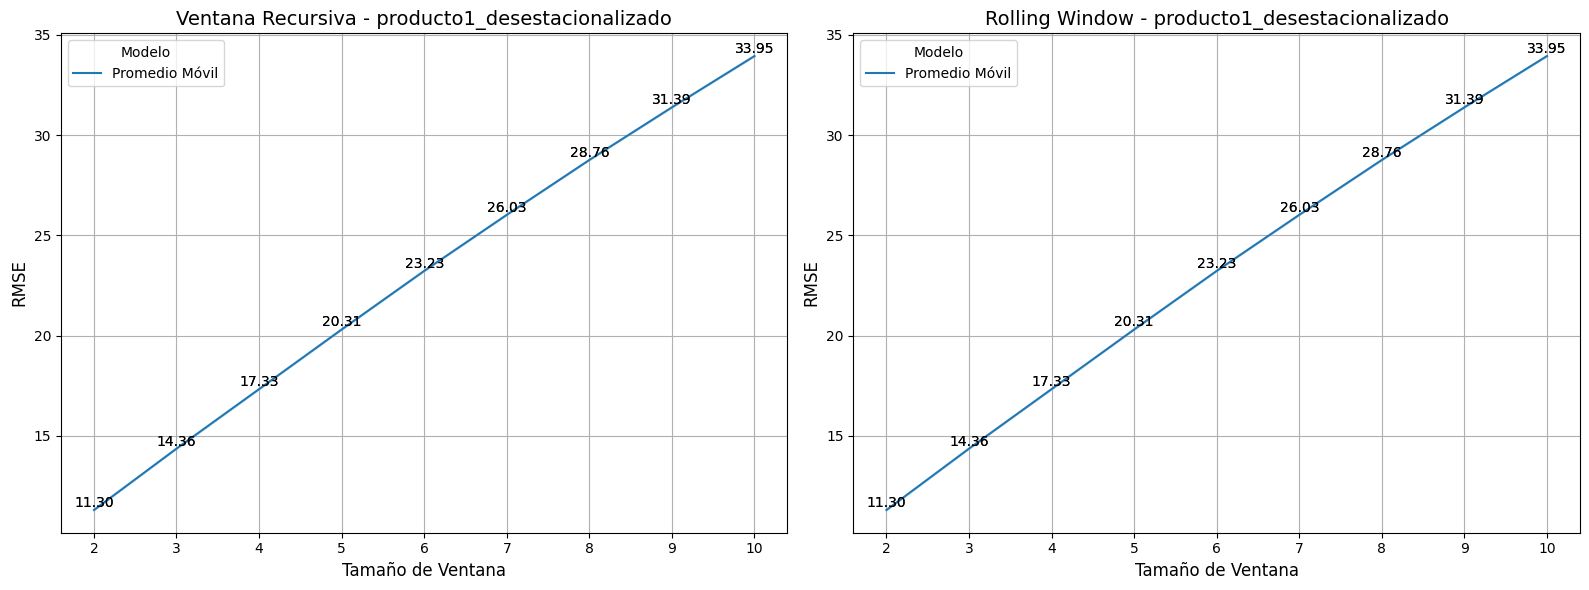

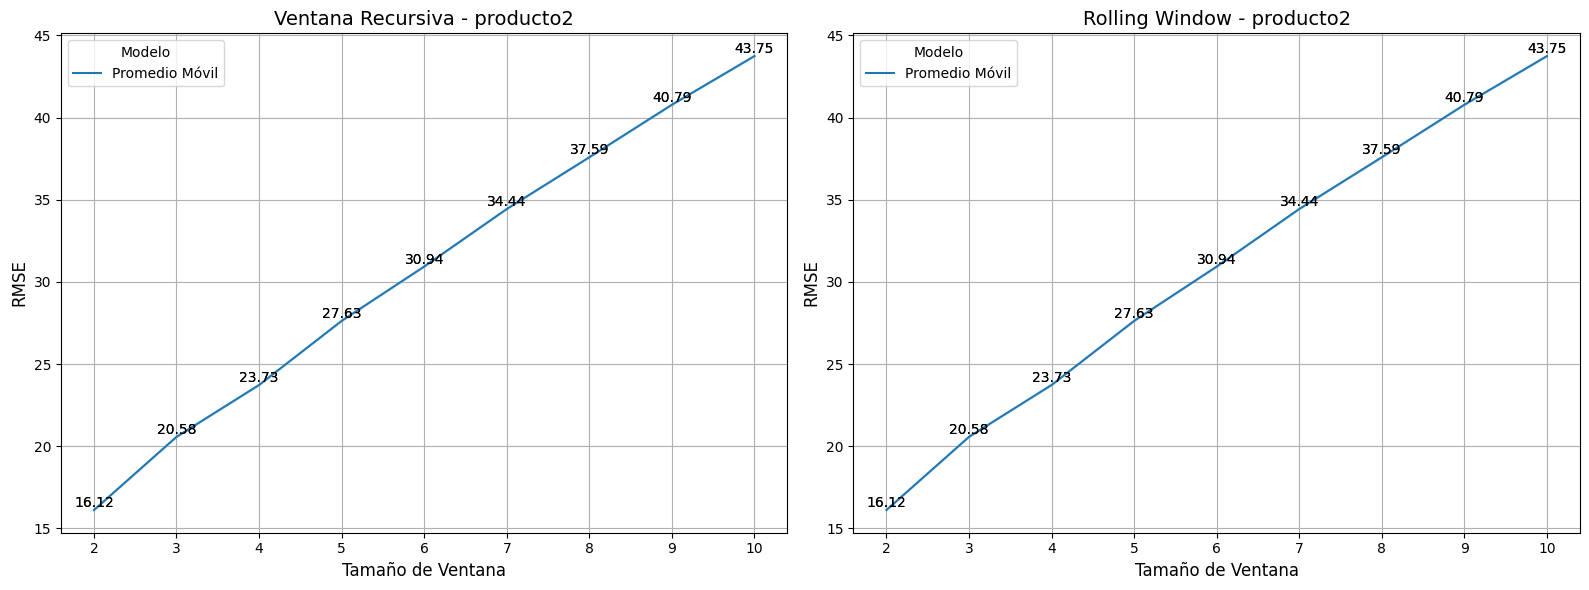

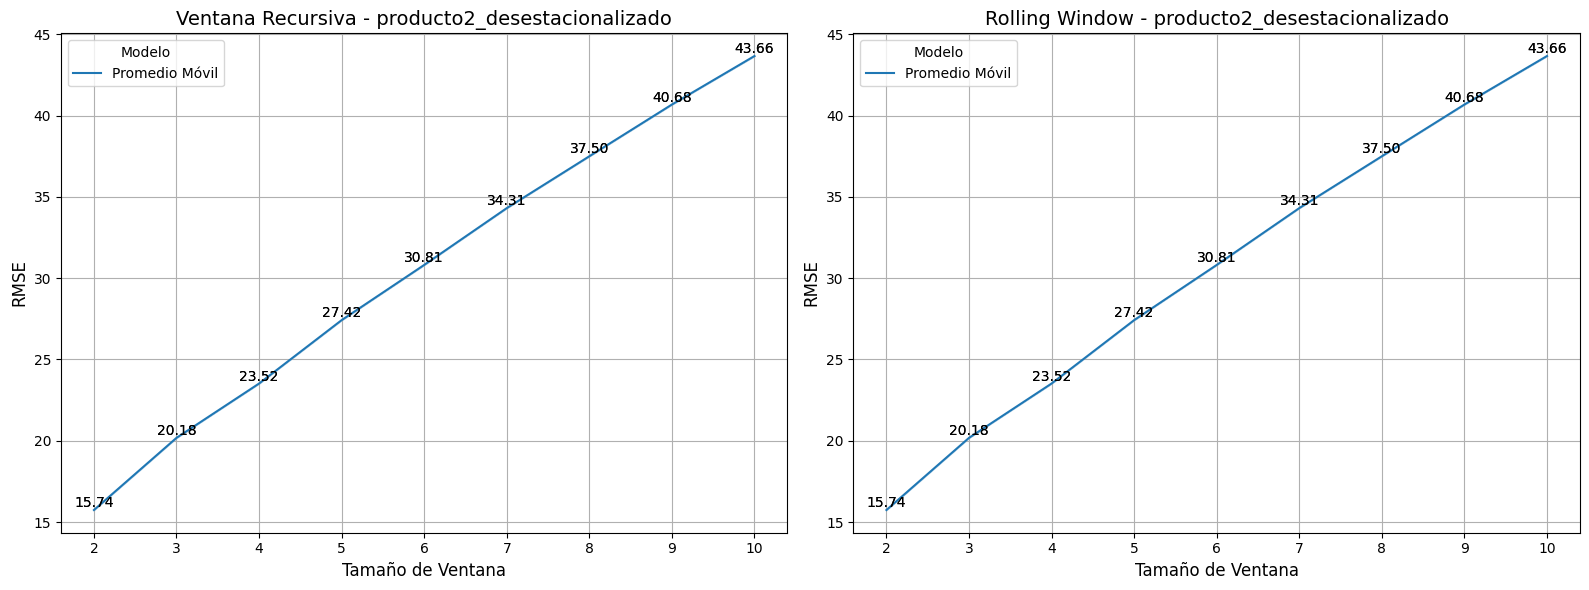

In [79]:
# Llamar a la función para graficar el DataFrame con gráficos separados por serie y protocolo
graficar_separado_por_protocolo_y_serie(resultados_df)

In [99]:
# Ejecutar la función para seleccionar el mejor modelo
mejores_modelos = seleccionar_mejor_modelo_con_hiperparametros(resultados_df)

# Mostrar los mejores modelos para cada serie
print(mejores_modelos)

                          Serie    Mejor Modelo       Protocolo Ventana  \
0                     producto1  Promedio Móvil  Rolling Window       2   
1  producto1_desestacionalizado  Promedio Móvil  Rolling Window       2   
2                     producto2  Promedio Móvil  Rolling Window       2   
3  producto2_desestacionalizado  Promedio Móvil  Rolling Window       2   

  Hiperparámetros       RMSE  
0            None  11.491006  
1            None  11.299977  
2            None  16.122020  
3            None  15.742007  


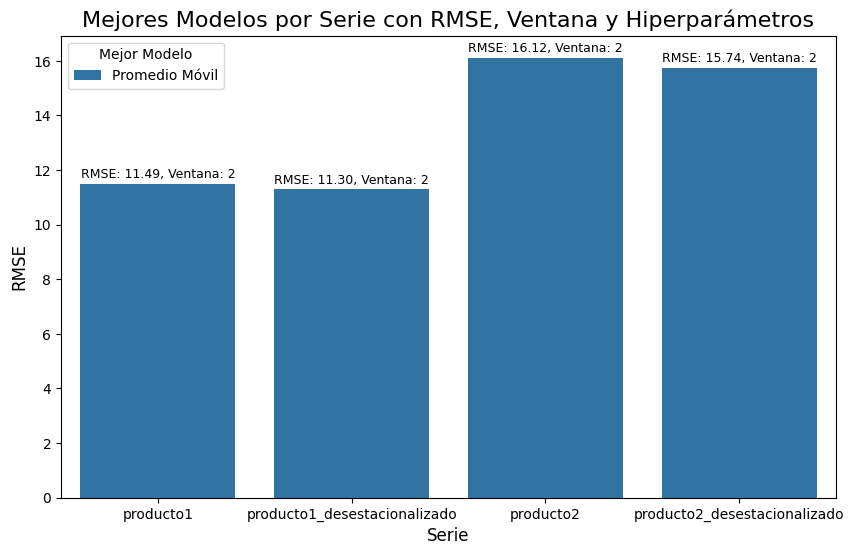

In [100]:
# Llamar a la función para graficar los mejores modelos
graficar_mejores_modelos_con_parametros(mejores_modelos)


Ahora procedemos a usar optimización bayesiana para observar que tanto mejeora, pues en teoría debería ser mejor, aúnque aquí no tenemos hiperparámetros es meramente académico el ejercio. (creemos)

In [111]:
# Separar los datos en conjunto de entrenamiento y prueba
train_data = data[:int(0.8 * len(data))]  # 80% para entrenamiento
test_data = data[int(0.8 * len(data)):]   # 20% para prueba


In [114]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101 entries, 2008-01-31 to 2016-05-31
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   producto1                     101 non-null    float64
 1   producto2                     101 non-null    float64
 2   producto1_desestacionalizado  101 non-null    float64
 3   producto2_desestacionalizado  101 non-null    float64
dtypes: float64(4)
memory usage: 3.9 KB


In [115]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26 entries, 2016-06-30 to 2018-07-31
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   producto1                     26 non-null     float64
 1   producto2                     26 non-null     float64
 2   producto1_desestacionalizado  26 non-null     float64
 3   producto2_desestacionalizado  26 non-null     float64
dtypes: float64(4)
memory usage: 1.0 KB


In [131]:
# Lista de series a optimizar
series_a_evaluar = {
    'producto1': 'producto1',
    'producto1_desestacionalizado': 'producto1_desestacionalizado',
    'producto2': 'producto2',
    'producto2_desestacionalizado': 'producto2_desestacionalizado'
}

# Función para aplicar la optimización bayesiana para cada serie
def train_and_evaluate_RMSE_MA(window_size, serie_nombre, protocolo='rolling'):
    """Función para optimizar el tamaño de la ventana del Promedio Móvil para una serie específica."""
    
    # Redondear el tamaño de la ventana al valor entero más cercano
    window_size = int(round(window_size))  
    
    # Asegurarse de que el tamaño de la ventana sea al menos 2
    if window_size < 2:
        window_size = 2
    
    # Aplicar el protocolo de evaluación con Rolling Window o Ventana Recursiva
    if protocolo == 'rolling':
        predicciones = evaluacion_rolling_window_un_paso(train_data[serie_nombre], modelo_promedio_movil, {'window': window_size}, window_size=window_size)
    elif protocolo == 'recursiva':
        predicciones = evaluacion_ventana_recursiva_un_paso(train_data[serie_nombre], modelo_promedio_movil, {'window': window_size}, initial_train_size=window_size)
    
    # Solo tomamos los últimos valores reales correspondientes a la longitud de las predicciones generadas
    valores_reales_correspondientes = test_data[serie_nombre][-len(predicciones):]
    
    # Calcular RMSE con los valores reales y predichos
    rmse = np.sqrt(mean_squared_error(valores_reales_correspondientes, predicciones))
    
    # Imprimir el tamaño de la ventana, el nombre de la serie y el RMSE obtenido (para seguimiento)
    print(f"Serie: {serie_nombre}, Ventana: {window_size}, RMSE: {rmse}")
    
    return -rmse  # Negativo porque BayesianOptimization maximiza por defecto

# Definir el espacio de búsqueda para el tamaño de la ventana
pbounds_ma = {
    'window_size': (2, 15)  # El rango de la ventana de 2 a 15
}

In [132]:

# Ejecutar la optimización para cada serie
for serie_nombre in series_a_evaluar.values():
    print(f"Optimizando para {serie_nombre}...")

    # Optimización Bayesiana para la serie específica usando Rolling Window
    optimizer_ma = BayesianOptimization(
        f=lambda window_size: train_and_evaluate_RMSE_MA(window_size, serie_nombre, protocolo='rolling'),
        pbounds=pbounds_ma,
        random_state=1,
        verbose=2
    )

    # Ejecutar la optimización bayesiana
    optimizer_ma.maximize(init_points=3, n_iter=50)

    # Mostrar el mejor resultado
    print(f"Mejor resultado para {serie_nombre}: {optimizer_ma.max}")

Optimizando para producto1...
|   iter    |  target   | window... |
-------------------------------------


ValueError: Found input variables with inconsistent numbers of samples: [26, 94]